## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

Start by importing the required libraries:

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Read in the `ab_data.csv` data and store it as `df`.

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.query('converted == 1').user_id.nunique() / df.shape[0]

0.1194418598333322

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
#sum the values where there is either new_page or treatment but not both
df.query('landing_page == "new_page" and group != "treatment"').user_id.count() + df.query('group == "treatment" and landing_page != "new_page"').user_id.count()

3893

f. Check if the rows have missing values

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**No missing values in the dataset**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Create a new dataset that only includes data we understand and can process.  Store the new dataframe in **df2**.

In [9]:
no_match = df.query(('(landing_page == "new_page" and group != "treatment") | (landing_page == "old_page" and group != "control")'))
no_match.head()

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0


In [10]:
#drop rows where treatment and new page do not match, and where control and old page do not match
df2 = df.drop(no_match.index)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Quiz Questions:

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2.user_id.value_counts().head(1)
#773192 is duplicated

773192    2
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [14]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep the dataframe as **df2**.

In [15]:
df2.drop(2893,inplace=True)

In [16]:
df2.query('user_id == "773192"')
#confirm there is now only one row for this user_id

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Quiz Questions:

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.query('converted == 1').user_id.count() / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
p_conv_control = df2.query('group == "control"')['converted'].sum() / df2.query('group == "control"').shape[0]
print(p_conv_control)

0.1203863045


**The control group converted 12.0% of the time**

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
p_conv_treatment = df2.query('group == "treatment"')['converted'].sum() / df2.query('group == "treatment"').shape[0]
print(p_conv_treatment)

0.118808065515


**The treatment group converted 11.9% of the time, slightly less than the control group**

In [31]:
obs_diff = p_conv_treatment - p_conv_control
print(obs_diff)

-0.00157823898536


**The actual observed difference in conversion between the new and the old page is -0.0015. This is the statistic that we need to assess the significance of**.

d. What is the probability that an individual received the new page?

In [32]:
df2.query('landing_page == "new_page"').user_id.count() / df2.shape[0]

0.50006194422266881

**50% of individuals received the new page**

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Based on our observed statistic, right now I do not believe there is sufficient evidence to conclude that the new treatment leads to more conversions. This is supported by a lower probability of converting in the treatment group than in the control group.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses be?

**H0: The old page leads to as many or conversions as the new page, or** 

**$p_{new}$ - $p_{old}$ <= 0**

**H1: The new page leads to more conversions than the old page, or**

**$p_{new}$ - $p_{old}$ > 0**



`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Quiz 5 Questions:

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [33]:
p_new =df['converted'].sum() / df['converted'].count()
p_new

0.11965919355605512

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [34]:
p_old = df['converted'].sum() / df['converted'].count()
p_old

0.11965919355605512

c. What is $n_{new}$, the number of individuals in the treatment group?

In [35]:
n_new = df2[df2['group'] == 'treatment'].user_id.count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [36]:
n_old = df2[df2['group'] == 'control'].user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [37]:
# 1 conversion event per test, p_new probability of conversion, do this n_new times
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 1, 0, ..., 0, 1, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [38]:
old_page_converted = np.random.binomial(1, p_new, n_new)
old_page_converted

array([0, 0, 1, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [39]:
simulated_obs_diff = new_page_converted.mean() - old_page_converted.mean()
simulated_obs_diff

-0.0016034684467689797

#### This is our simulated observed difference. Now we need to create a distribution under the null to see if it is significant

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [40]:
p_diffs = []

for _ in range (10000):
    new_conversion_sample = np.random.binomial(1,p_new,n_new)
    old_conversion_sample = np.random.binomial(1,p_old,n_old)
    p_diffs.append(new_conversion_sample.mean() - old_conversion_sample.mean())

**Below is an alternative approach to creating the sampling ditribution with bootstrapping**

In [41]:
# p_diffs2 = []

# for i in range (10000):
#     bootsample = df2.sample(df2.shape[0],replace=True)
#     new_conv_mean = bootsample[bootsample['group'] == 'treatment']['converted'].mean()
#     old_conv_mean = bootsample[bootsample['group'] == 'control']['converted'].mean()
#     mean_diff = new_conv_mean - old_conv_mean
#     p_diffs2.append(mean_diff)

In [42]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?

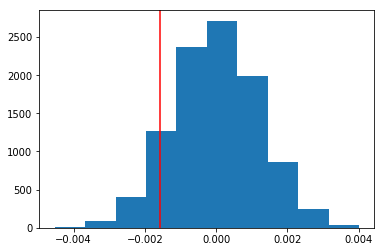

In [43]:
plt.hist(p_diffs)
plt.axvline(obs_diff,color='red')

This is sampling distribution of the mean difference in conversion probabilities between those who saw the new page and the old page, run 10000 times. The distribution appears as expected with the null hypothesis - it is normally distributed around zero and our observed mean difference value falls within the distribution.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [44]:
(p_diffs > obs_diff).mean()

0.90549999999999997

k. Explain what was computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

#### We can see that ~90% of mean conversion differences in the sampling distribution are larger than our mean observed difference. The p-value is 0.9055, which means that using an alpha type 1 error rate of 0.05, we fail to reject the null hypothesis. It seems likely that our statistic falls within the null distribution, and we do not have evidence that viewing the new page leads to a higher conversion rate

**Below is another alternative approach, if we want to assess our observed conversion difference against a true null sampling distribution. In this case the p-value is 0.9012, which is > 0.05 type 1 error rate, so again we fail to reject the null hypothesis.**

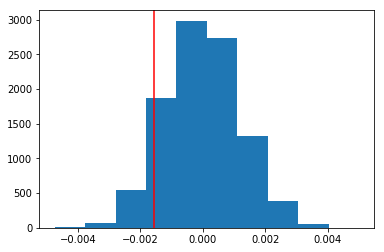

In [47]:
#in order to determine a p-value and make an assessment on the null hypothesis, we need to create a sampling distribution around the null
null_vals = np.random.normal(0,p_diffs.std(),p_diffs.size)
plt.hist(null_vals)
plt.axvline(obs_diff,color='red')

In [48]:
(null_vals > obs_diff).mean()

0.9012

**Put your answer here.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [49]:
import statsmodels.api as sm

convert_old = df2[df2['landing_page']== 'old_page']['converted'].sum()
convert_new = df2[df2['landing_page']== 'new_page']['converted'].sum()
n_old = len(df2[df2['landing_page']=='old_page']) 
n_new = len(df2[df2['landing_page']=='new_page']) 

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [50]:
print(convert_old)
print(convert_new)
print(n_old)
print(n_new)

17489
17264
145274
145310


m. Now use `stats.proportions_ztest` to compute the test statistic and p-value.  [Here]

In [51]:
from statsmodels.stats.proportion import proportions_ztest
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new,convert_old], nobs=[n_new,n_old],alternative ='larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The Z-score tells us how far from the mean a data point is, in terms of standard deviations. The Z-score of -1.31 means that the convertion rate for the new page is 1.31 standard deviations below the mean. The Z score is within 2 standard deviations (95% confidence interval) of the null distribution, which indicates that we should fail to reject the null hypothesis. The p-value of 0.905 supports this conclusion, as it exceeds the type 1 error threshold of 0.05.**

**From a practical perspective, there is not enough evidence that switching to the new landing page will lead to an increase in conversions for the company. Recommendation would be to stay with the old landing page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` The result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should be performed in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received - 1 for if individual receives the **treatment** and 0 if **control**.

In [52]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2 = df2.rename(columns={'treatment':'ab_page'})
df2.drop(columns='control',inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns created in part b., then fit the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [53]:
log_model = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = log_model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-06 14:24 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

d. Provide the summary of the model below, and use it as necessary to answer the following questions.

In [54]:
1/np.exp(-0.0150)

1.0151130646157189

**All things held equal, an individual who got the new landing page (treatment group) is 1.015 times LESS likely to convert than those who got the old landing page (control group)**

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

**The p-value for ab_page is 0.1899. This regression p-value is used to test a null hypothesis that there is no correlation between the independent variable (the page the user saw) and the dependent variable (whether they converted). Using an alpha type 1 error rate of 0.05, the p-value of 0.1899 would indicate that there is not enough evidence to reject the null, and thus there is not a significant relationship between the page a user is shown and conversions. The p-value in part II is not specific to a variable, and indicates the probability that the observed statistic obs_diff came from the null distribution.** 

**Furthermore the regression p-value is based on a two-tailed t-test considering both positive and negative correlations, while the p-value in part II is from a one-tailed t-test, only looking at whether the new page had a greater conversion rate**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding additional features will help us have a better understanding of which independent variables have the most significant impact on conversion rate. It will help us improve the fit of the linear regression model by increasing the R-squared value and reducing margin of error.
The downside would be the possibility of multicollinearity, where certain predictor variables are not independent of one another causing misleading results. The introduction of features with higher order terms (quadratics, cubics etc) can make the regression results more complicated to interpret.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?

In [55]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [56]:
df2 = df2.set_index('user_id').join(countries.set_index('user_id'))

In [57]:
df2[['CA','UK','US']] = pd.get_dummies(df2['country'])
df2['intercept'] = 1
df2.drop(columns = 'US')

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
user_id,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0
936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0
719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1


In [58]:
log_model = sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','UK']])
results = log_model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-06 14:24 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [59]:
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

**Canadian viewers are 1.04 times less likely (-4%) to convert than US viewers**

**UK viewers are 1.01 times more likely (+1%) to convert than US viewers**


**Based on p-values of 0.1295 for Canada and 0.4573 for UK, country does not appear to have a statistically significant effect on conversions. We fail to reject the null hypothesis.**

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

**Here we are looking to see if there is a difference in conversions amongst individuals from these countries who saw the new page**

In [60]:
df2['ca_ab_page'] = df2['CA']*df2['ab_page']
df2['uk_ab_page'] = df2['UK']*df2['ab_page']
df2['us_ab_page'] = df2['US']*df2['ab_page']

In [61]:
df2.head(20)

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,ca_ab_page,uk_ab_page,us_ab_page
user_id,,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0
936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1,0,0,0
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,1,0,0
719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1,0,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,0,1,0


**It's important that we also keep the lower order terms for both page and country as part of the regression. The US is being assumed as the default label, so we drop that column.**

In [62]:
log_model = sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','UK','ca_ab_page','uk_ab_page']])
results = log_model.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-12-06 14:24 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ca_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
uk_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

In [63]:
1/np.exp(-0.0469),np.exp(0.0314)

(1.0480172021191829, 1.0318981806179213)

**Canadian viewers who saw the new page are 1.05 times less likely (-5%) to convert than US viewers**

**UK viewers wo saw the new page are 1.03 times more likely (+3%) to convert than US viewers**

**Based on p-values of 0.3833 for ca_page and 0.2377 for uk_page, the interaction between country and ab_page does not appear to have a statistically significant effect on conversions. We fail to reject the null hypothesis.**

**From a practical perspective, we do NOT have evidence that supports an increase in conversions if the company shifted to the new landing page.**

<a id='conclusions'></a>
## Finishing Up


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0